# Import packages

In [4]:
# General
import pandas as pd
import numpy as np
import re

# Viz
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Optimization
from sklearn.model_selection import GridSearchCV

# Metrics and calibration
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
!pip install shap
import shap

# Suppress all future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.0 MB/s eta 0:00:00


# Import Data and inspect

In [5]:
raw = pd.read_csv('healthcare-dataset-stroke-data.csv')
raw.shape

(5110, 12)

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
raw.set_index('id',inplace=True)
raw.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


# Preprocessing

In [8]:
# Make a copy of the raw data
df = raw.copy()

# Discretize age into groups found in research corresponding with strokes
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3475622/
df['age'] = pd.cut(df['age'],
                   bins=[0, 19, 44, 54, 64, 74, 84],
                   labels=['0-19', '20-44', '45-54', '55-64', '65-74', '75-84'])

# KNN Imputation
imputer = KNNImputer(n_neighbors=2)
df['bmi'] = imputer.fit_transform(df[['bmi']])

# Discretize bmi and avg_glucose_level into groups found in research corresponding with strokes
df['bmi'] = pd.cut(df['bmi'],
                   bins=[0, 18.5, 24.9, 29.9, 100],
                   labels=['underweight', 'normal', 'overweight', 'obese'])

df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'],
                   bins=[0, 99, 125, 200, 500],
                   labels=['normal', 'pre-diabetic', 'diabetic', 'very diabetic'])

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=df.columns[:-1], drop_first=False)

# Resulting dataframe
df_encoded = df_encoded.astype(int)
df_encoded.head()

,stroke,gender_Female,gender_Male,gender_Other,age_0-19,age_20-44,age_45-54,age_55-64,age_65-74,age_75-84,...,avg_glucose_level_diabetic,avg_glucose_level_very diabetic,bmi_underweight,bmi_normal,bmi_overweight,bmi_obese,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,,,,,
9046,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
51676,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
31112,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
60182,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1665,1,1,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0


# Correlation Check

In [9]:
# Remove stroke from rows
styled_df = df_encoded.corr().iloc[1:,:].copy()

# Eliminate the diagonal
styled_df.replace(1,0,inplace=True)

# Sort columns by sum of correlations
sort_columns =list(styled_df.sum().sort_values(ascending=False).T.index)

# Style and round the dataframe
styled_df[sort_columns].sort_values('stroke',ascending=False).style.background_gradient(cmap='coolwarm').format("{:.2f}")

,stroke,gender_Other,work_type_Never_worked,bmi_underweight,avg_glucose_level_very diabetic,age_0-19,work_type_children,avg_glucose_level_diabetic,age_75-84,age_65-74,work_type_Self-employed,smoking_status_formerly smoked,work_type_Govt_job,heart_disease_1,hypertension_1,ever_married_No,smoking_status_Unknown,gender_Male,smoking_status_smokes,avg_glucose_level_pre-diabetic,Residence_type_Urban,age_55-64,bmi_normal,Residence_type_Rural,age_45-54,bmi_overweight,ever_married_Yes,gender_Female,hypertension_0,heart_disease_0,bmi_obese,smoking_status_never smoked,avg_glucose_level_normal,age_20-44,work_type_Private
age_75-84,0.23,-0.00,-0.02,-0.07,0.14,-0.16,-0.13,0.02,0.00,-0.11,0.24,0.08,-0.02,0.22,0.16,-0.17,-0.07,-0.02,-0.05,-0.04,0.03,-0.14,-0.02,-0.03,-0.14,0.09,0.17,0.02,-0.16,-0.22,-0.03,0.04,-0.06,-0.22,-0.08
heart_disease_1,0.13,-0.00,-0.02,-0.06,0.15,-0.11,-0.09,0.03,0.22,0.14,0.09,0.07,0.00,0.00,0.11,-0.11,-0.07,0.09,0.04,-0.02,0.00,0.04,-0.07,-0.00,-0.03,0.07,0.11,-0.09,-0.11,-1.00,0.03,-0.02,-0.09,-0.15,0.00
hypertension_1,0.13,-0.00,-0.02,-0.08,0.15,-0.16,-0.13,0.06,0.16,0.12,0.12,0.06,0.02,0.11,0.00,-0.16,-0.14,0.02,0.03,-0.03,-0.01,0.08,-0.10,0.01,0.03,0.01,0.16,-0.02,-1.00,-0.11,0.12,0.07,-0.10,-0.14,-0.01
avg_glucose_level_very diabetic,0.11,-0.00,-0.02,-0.07,0.00,-0.13,-0.11,-0.11,0.14,0.14,0.06,0.09,0.02,0.15,0.15,-0.16,-0.10,0.03,0.02,-0.15,-0.00,0.08,-0.12,0.00,0.00,0.00,0.16,-0.03,-0.15,-0.15,0.14,0.01,-0.37,-0.13,0.02
ever_married_Yes,0.11,-0.02,-0.09,-0.33,0.16,-0.66,-0.54,0.03,0.17,0.20,0.19,0.17,0.13,0.11,0.16,-1.00,-0.33,-0.03,0.11,-0.04,0.01,0.24,-0.22,-0.01,0.24,0.14,0.00,0.03,-0.16,-0.11,0.24,0.10,-0.07,-0.05,0.15
age_65-74,0.10,-0.00,-0.02,-0.08,0.14,-0.16,-0.13,0.01,-0.11,0.00,0.14,0.13,0.01,0.14,0.12,-0.20,-0.10,0.01,-0.00,-0.03,-0.00,-0.14,-0.10,0.00,-0.14,0.09,0.20,-0.01,-0.12,-0.14,0.05,0.00,-0.06,-0.22,-0.02
bmi_overweight,0.07,-0.01,-0.01,-0.18,0.00,-0.18,-0.18,0.00,0.09,0.09,0.06,0.03,0.02,0.07,0.01,-0.14,-0.10,0.05,0.05,0.01,-0.01,0.03,-0.38,0.01,0.01,0.00,0.14,-0.05,-0.01,-0.07,-0.53,0.03,-0.01,0.01,0.07
smoking_status_formerly smoked,0.06,0.03,-0.03,-0.10,0.09,-0.18,-0.16,-0.01,0.08,0.13,0.09,0.00,0.03,0.07,0.06,-0.17,-0.30,0.04,-0.20,-0.02,0.01,0.08,-0.07,-0.01,0.03,0.03,0.17,-0.04,-0.06,-0.07,0.09,-0.35,-0.03,-0.07,0.03
work_type_Self-employed,0.06,-0.01,-0.03,-0.10,0.06,-0.19,-0.17,0.02,0.24,0.14,0.00,0.09,-0.17,0.09,0.12,-0.19,-0.11,-0.03,-0.00,-0.02,0.01,0.04,-0.06,-0.01,0.01,0.06,0.19,0.03,-0.12,-0.09,0.04,0.03,-0.03,-0.13,-0.51
avg_glucose_level_diabetic,0.05,0.04,0.01,-0.02,-0.11,-0.01,-0.02,0.00,0.02,0.01,0.02,-0.01,-0.01,0.03,0.06,-0.03,-0.01,0.02,-0.00,-0.18,0.01,0.03,-0.02,-0.01,0.01,0.00,0.03,-0.02,-0.06,-0.03,0.02,0.02,-0.43,-0.04,0.00


# Oversample the minority class and undersample the majority class

In [10]:
# Correct sampling
X = df_encoded.drop('stroke', axis=1)
y = df_encoded.stroke

# Random Forest Train and Tune Model

In [11]:
# Assuming 'X' and 'y' are your features and labels respectively
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=101, test_size=0.1, stratify=y_temp)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('Original dataset shape', len(df_encoded))
print('Resampled dataset shape', len(y_res))
print('Validation dataset shape\n', y_val.value_counts())
print('Stroke count in resampled dataset\n', y_res.value_counts())


# Create RandomForestClassifier
clf = RandomForestClassifier(random_state=40)

# Define a param_grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Custom scorer
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score, zero_division=0)
precision_scorer = make_scorer(precision_score, zero_division=0, average='binary')
f1_scorer = make_scorer(f1_score, zero_division=0, average='binary')
auc_scorer = make_scorer(roc_auc_score)

# Now put them in a dictionary
scorers = {
    'Accuracy': accuracy_scorer,
    'Recall': recall_scorer,
    'Precision': precision_scorer,
    'F1': f1_scorer,
    'AUC': 'roc_auc'
}

# Set up GridSearchCV with the scoring dictionary
grid = GridSearchCV(clf, param_grid, scoring=scorers, refit='F1', return_train_score=True, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid.fit(X_res, y_res)

# Get best estimator found by grid search and print predictions on the training set
best_estimator = grid.best_estimator_
y_res_pred = best_estimator.predict(X_res)

# Classification report for the training set
train_report = classification_report(y_res, y_res_pred)

# After finding the best hyperparameters, evaluate on the validation set
y_val_pred = grid.predict(X_val)
val_report = classification_report(y_val, y_val_pred)

# Predictions on the validation set
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
train_confusion_matrix = confusion_matrix(y_res, y_res_pred)
val_confusion_df = pd.DataFrame(val_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])
train_confusion_df = pd.DataFrame(train_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])



Original dataset shape 5110
Resampled dataset shape 7778
Validation dataset shape
 0    874
1     45
Name: stroke, dtype: int64
Stroke count in resampled dataset
 0    3889
1    3889
Name: stroke, dtype: int64


# Performance results

## Metrics

In [12]:
# Get the results
print('Best params:', grid.best_params_)
print('Best estimator:', grid.best_estimator_)
print(f'Best AUC: {grid.best_score_:.2f}')

Best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=8, max_features='auto',
                       n_estimators=200, random_state=40)
Best AUC: 0.91


Train confusion matrix
                Predicted_Negative  Predicted_Positive
True_Negative                3262                 627
True_Positive                  60                3829



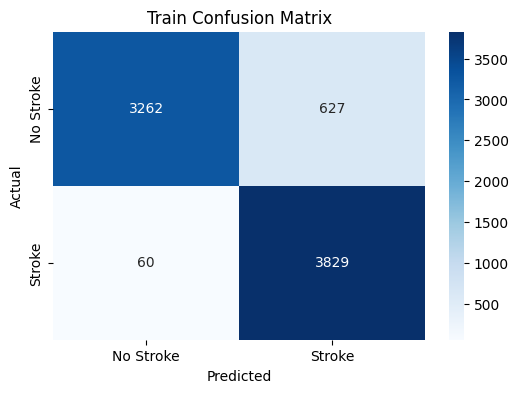

Validation confusion matrix
                Predicted_Negative  Predicted_Positive
True_Negative                 711                 163
True_Positive                  18                  27



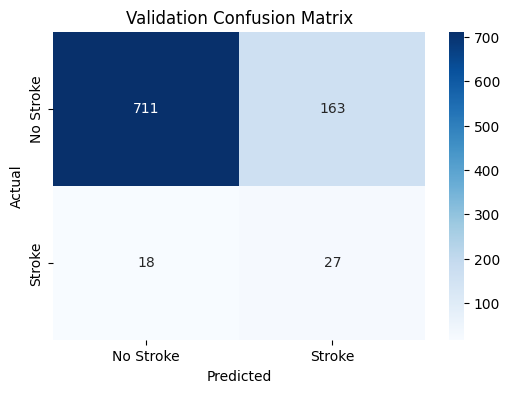

In [13]:
# Train confusion matrix
print('Train confusion matrix\n', train_confusion_df)
print()
plt.figure(figsize=(6, 4))
sns.heatmap(train_confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Validation confusion matrix
print('Validation confusion matrix\n', val_confusion_df)
print()
plt.figure(figsize=(6, 4))
sns.heatmap(val_confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      3889
           1       0.86      0.98      0.92      3889

    accuracy                           0.91      7778
   macro avg       0.92      0.91      0.91      7778
weighted avg       0.92      0.91      0.91      7778




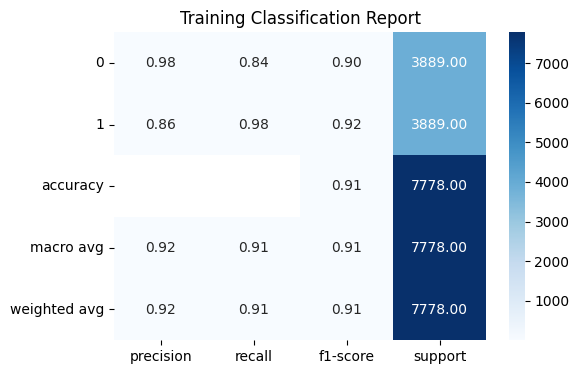

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89       874
           1       0.14      0.60      0.23        45

    accuracy                           0.80       919
   macro avg       0.56      0.71      0.56       919
weighted avg       0.93      0.80      0.85       919




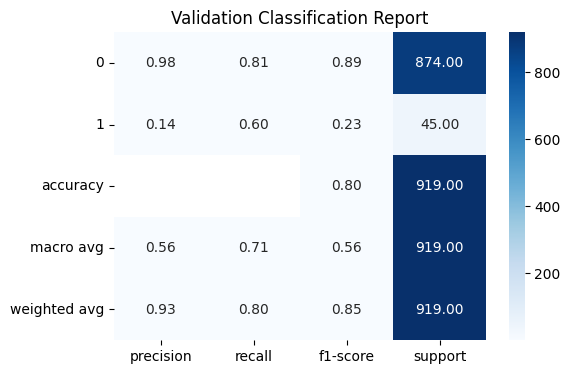

In [14]:
# Train Classification report
print("Training Classification Report:\n", train_report)
print()

# Plot classification report for training set
dic_train_report = classification_report(y_res, y_res_pred, output_dict=True)
train_report_df = pd.DataFrame(dic_train_report).transpose()
train_report_df.loc['accuracy', 'precision'] = np.nan
train_report_df.loc['accuracy', 'recall'] = np.nan
train_report_df.loc['accuracy', 'support'] = train_report_df.loc['macro avg', 'support']
plt.figure(figsize=(6, 4))
sns.heatmap(train_report_df, annot=True, cmap='Blues', fmt='.2f')
plt.title("Training Classification Report")
plt.show()

# Validation Classification report
print("Validation Classification Report:\n", val_report)
print()

# Plot classification report for validation set
dic_val_report = classification_report(y_val, y_val_pred, output_dict=True)
validation_report_df = pd.DataFrame(dic_val_report).transpose()
validation_report_df.loc['accuracy', 'precision'] = np.nan
validation_report_df.loc['accuracy', 'recall'] = np.nan
validation_report_df.loc['accuracy', 'support'] = validation_report_df.loc['macro avg', 'support']
plt.figure(figsize=(6, 4))
sns.heatmap(validation_report_df, annot=True, cmap='Blues', fmt='.2f')
plt.title("Validation Classification Report")
plt.show()

## Visualizations

In [15]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))


Length of X_train: 4088
Length of y_train: 4088


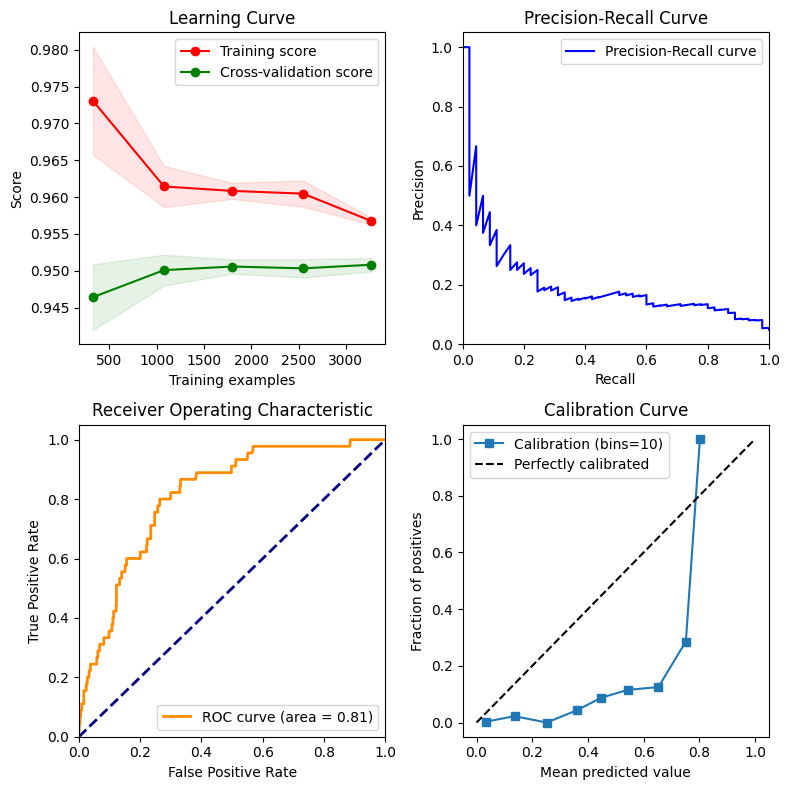

In [16]:
# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_estimator,
    X = X_train,
    y = y_train,
    train_sizes = [0.1, 0.33, 0.55, 0.78, 1. ],
    cv = 5,
    scoring = 'accuracy'
)

# Calculating mean and standard deviation for train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# For the ROC and precision-recall curves, you need probability scores
y_train_scores = grid.predict_proba(X_train)[:, 1]  # Probabilities for the positive class on the training set
y_val_scores = grid.predict_proba(X_val)[:, 1]      # Probabilities for the positive class on the validation set

# ROC Curve for Validation Set
fpr, tpr, _ = roc_curve(y_val, y_val_scores)
roc_auc = roc_auc_score(y_val, y_val_scores)

# Precision-Recall Curve for Validation Set
precision, recall, _ = precision_recall_curve(y_val, y_val_scores)

# Calibration Curve for Validation Set
prob_true, prob_pred = calibration_curve(y_val, y_val_scores, n_bins=10)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Learning Curve
axes[0, 0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
axes[0, 0].fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                        validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
axes[0, 0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0, 0].plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0, 0].set_title("Learning Curve")
axes[0, 0].set_xlabel("Training examples")
axes[0, 0].set_ylabel("Score")
axes[0, 0].legend(loc="best")

# Update the precision-recall curve plot to a continuous line graph
axes[0, 1].clear()  # Clearing the previous step plot
axes[0, 1].plot(recall, precision, color='b', label='Precision-Recall curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="best")

# ROC Curve
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Receiver Operating Characteristic')
axes[1, 0].legend(loc="lower right")

# Calibration Curve
axes[1, 1].plot(prob_pred, prob_true, 's-', label='Calibration (bins=10)')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
axes[1, 1].set_ylabel('Fraction of positives')
axes[1, 1].set_xlabel('Mean predicted value')
axes[1, 1].set_title('Calibration Curve')
axes[1, 1].legend(loc="best")

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import precision_recall_curve, auc

# Predict probabilities
y_scores = best_estimator.predict(X_train).ravel()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, y_scores)

# Calculate the AUC
pr_auc = auc(recall, precision)

print(pr_auc)

# Predict probabilities
y_scores = best_estimator.predict(X_res).ravel()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_res, y_scores)

# Calculate the AUC
pr_auc = auc(recall, precision)

print(pr_auc)

# Predict probabilities
y_scores = best_estimator.predict(X_val).ravel()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_scores)

# Calculate the AUC
pr_auc = auc(recall, precision)

print(pr_auc)

0.5286756122342997
0.9257883892468424
0.3808458851154


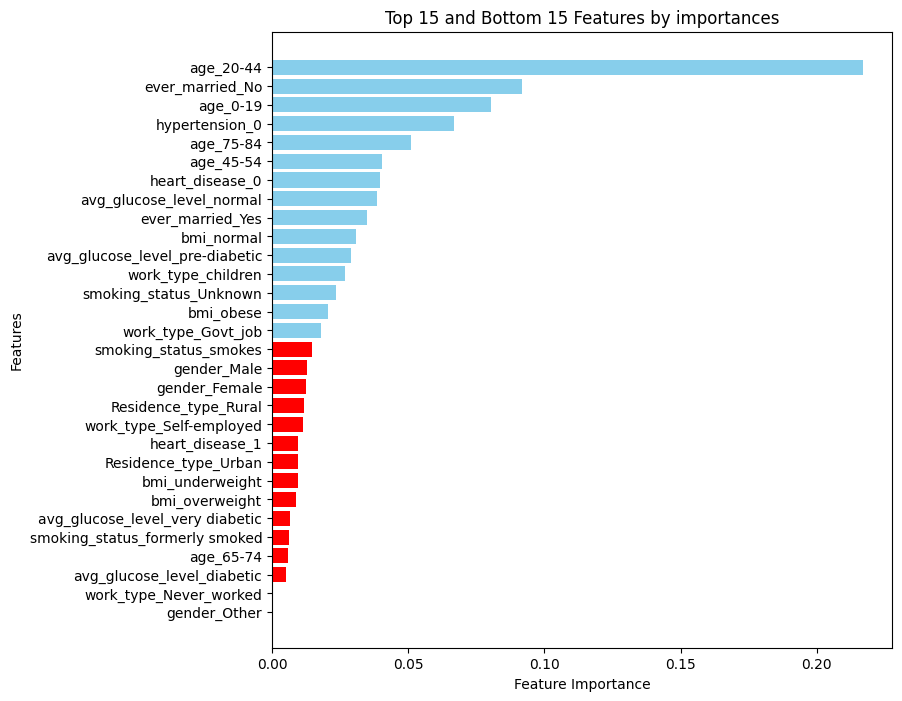

In [18]:
# Extracting importance
importances = best_estimator.feature_importances_

# Feature names
feature_names = X_train.columns

# Creating a DataFrame for features importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sorting importance
importance_df.sort_values('importance', ascending=True, inplace=True)

# Selecting top 10 and bottom 10 features
num_to_show = 15
top = importance_df.head(num_to_show)
bottom = importance_df.tail(num_to_show)

# Concatenating for the plot
selected_features = pd.concat([top, bottom])

# Coloring top and bottom bars differently
plt.figure(figsize=(8, 8))
plt.barh(top['feature'], top['importance'], color='red')
plt.barh(bottom['feature'], bottom['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Top {num_to_show} and Bottom {num_to_show} Features by importances')
plt.show()

In [19]:
# Max Importance Value
importance_df[importance_df['importance'] == importance_df['importance'].max()]

,feature,importance
4,age_20-44,0.216804


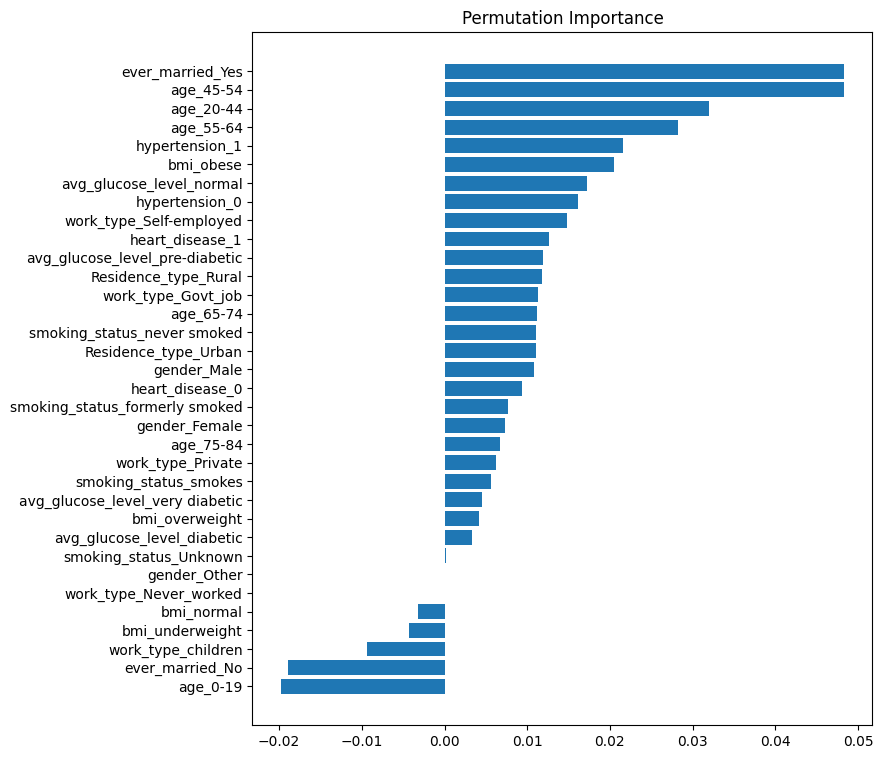

In [20]:
# Permutation Importance:
# https://scikit-learn.org/stable/modules/permutation_importance.html
# This method shuffles the values of each feature and observes the impact on model performance.
# Features with the highest drop in performance when shuffled are considered more important.

result = permutation_importance(best_estimator, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 9))
plt.barh(range(X_train.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.title("Permutation Importance")
plt.show()

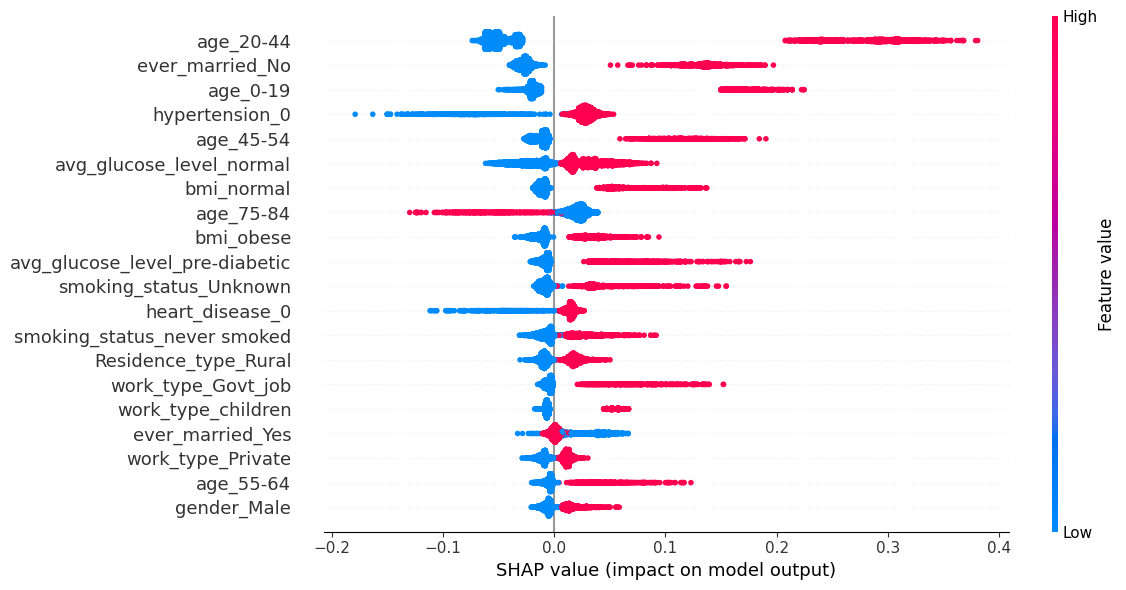

In [21]:
# SHAP
# https://shap.readthedocs.io/en/latest/index.html
# SHAP values provide a measure of the impact of each feature on the model output.
# Y-axis indicates the feature names in order of importance from top to bottom.
# X-axis represents the SHAP value, which indicates the degree of change in log odds.
# The color of each point on the graph represents the value of the corresponding feature, with red indicating high values and blue indicating low values.

explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train, plot_size=[12, 6])

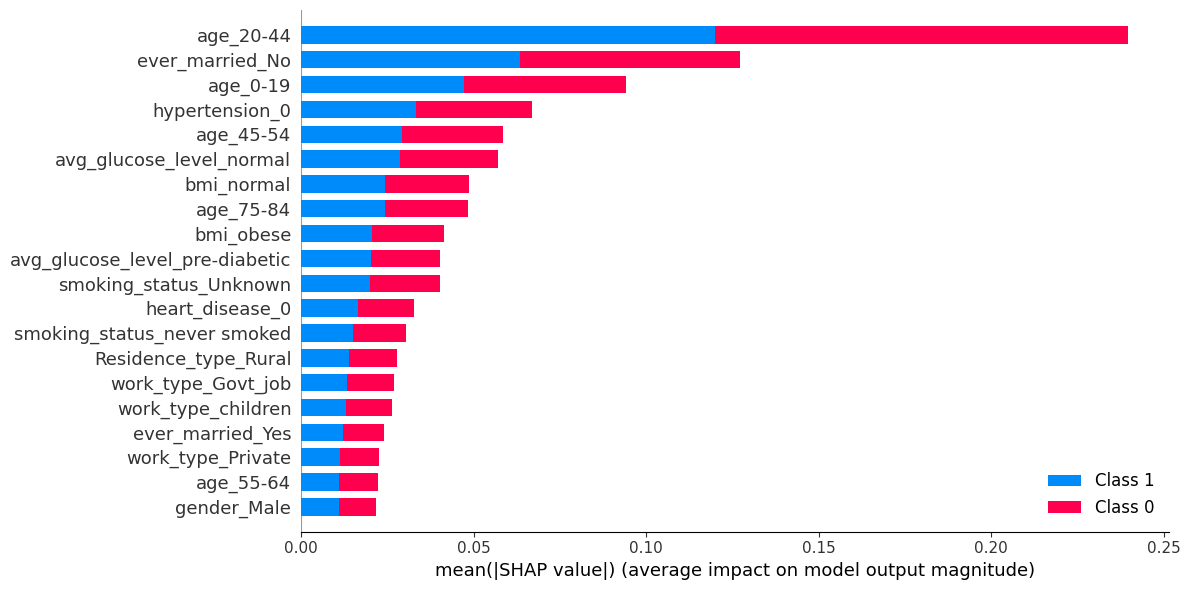

In [22]:
shap.summary_plot(shap_values, X_train, plot_size=[12, 6])

# Test Result

Train confusion matrix
                Predicted_Negative  Predicted_Positive
True_Negative                3954                 809
True_Positive                 109                4654



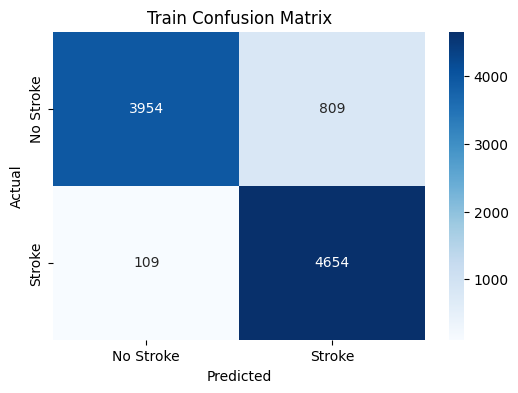

Training Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.83      0.90      4763
           1       0.85      0.98      0.91      4763

    accuracy                           0.90      9526
   macro avg       0.91      0.90      0.90      9526
weighted avg       0.91      0.90      0.90      9526




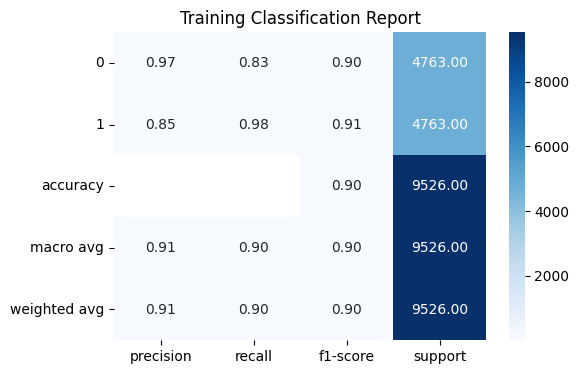

In [26]:

# Use the full dataset after smoting the validation dataset
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

X_DL_train_optimal = pd.concat([X_res, X_val_smote])
Y_DL_train_optimal = pd.concat([y_res, y_val_smote])

# print("X_DL_train_optimal.shape = ", X_DL_train_optimal.shape)
# print("Y_DL_train_optimal.shape = ", Y_DL_train_optimal.shape)

# Fit the grid search to the data
grid.fit(X_DL_train_optimal, Y_DL_train_optimal)

# Get best estimator found by grid search and print predictions on the training set
best_estimator = grid.best_estimator_
y_train_pred = best_estimator.predict(X_DL_train_optimal)


# Classification report for the training set
train_report = classification_report(Y_DL_train_optimal, y_train_pred)



# Predictions on the train set
train_confusion_matrix = confusion_matrix(Y_DL_train_optimal, y_train_pred)

train_confusion_df = pd.DataFrame(train_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])

# Train confusion matrix
print('Train confusion matrix\n', train_confusion_df)
print()
plt.figure(figsize=(6, 4))
sns.heatmap(train_confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train Classification report
print("Training Classification Report:\n", train_report)
print()

# Plot classification report for training set
dic_train_report = classification_report(Y_DL_train_optimal, y_train_pred, output_dict=True)
train_report_df = pd.DataFrame(dic_train_report).transpose()
train_report_df.loc['accuracy', 'precision'] = np.nan
train_report_df.loc['accuracy', 'recall'] = np.nan
train_report_df.loc['accuracy', 'support'] = train_report_df.loc['macro avg', 'support']
plt.figure(figsize=(6, 4))
sns.heatmap(train_report_df, annot=True, cmap='Blues', fmt='.2f')
plt.title("Training Classification Report")
plt.show()

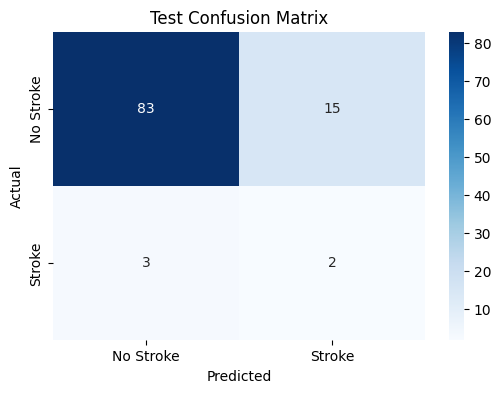

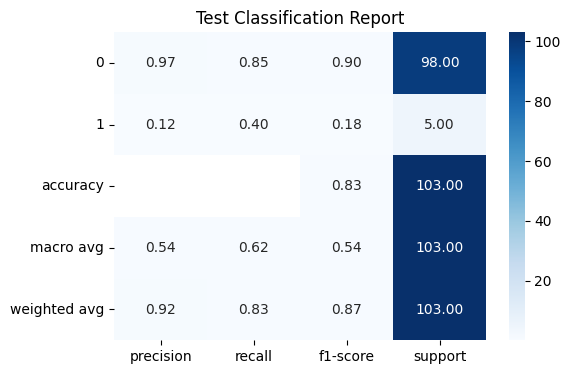

In [35]:
# **** Predictions for the ACTUAL HOLDOUT (TEST) set *****
y_test_pred = grid.predict(X_test)

test_report = classification_report(y_test, y_test_pred)

test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

test_confusion_df = pd.DataFrame(test_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])

# Test Confusion Matrix
print('Test confusion matrix\n', test_confusion_df)
print()

# Test Classification report
print("Test Classification Report:\n", test_report)
print()

# Plot Confusion Matrix for Test set
plt.figure(figsize=(6, 4))
sns.heatmap(test_confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



# Plot Classification report for Test set
dic_test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_report_df = pd.DataFrame(dic_test_report).transpose()
test_report_df.loc['accuracy', 'precision'] = np.nan
test_report_df.loc['accuracy', 'recall'] = np.nan
test_report_df.loc['accuracy', 'support'] = test_report_df.loc['macro avg', 'support']
plt.figure(figsize=(6, 4))
sns.heatmap(test_report_df, annot=True, cmap='Blues', fmt='.2f')
plt.title("Test Classification Report")
plt.show()